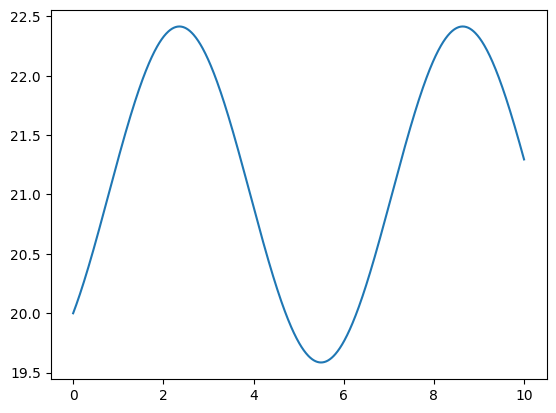

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# y' = sin(x) + cos(x) という微分方程式を解く
class Diff_Eq:
    
    bias = 20.0
    
    x0 = 0.0
    
    @staticmethod
    def y_prime(x, y):
        return torch.sin(x) + torch.cos(x)
    
    @classmethod
    def y0(cls):
        return 0.0 + cls.bias
    
    @classmethod
    def y(cls, x):
        return torch.sin(x) - torch.cos(x) + 1.0 +  cls.bias

# y' = - x y^2 という微分方程式を解く
# class Diff_Eq:
    
#     x0 = 1.
    
#     @staticmethod
#     def y_prime(x, y):
#         return - x * y ** 2
    
#     @staticmethod
#     def y0():
#         return 1.0 
    
#     @staticmethod
#     def y(x):
#         return 2 / (1 + x ** 2) 


# y' = - 2 x y という微分方程式を解く
# class Diff_Eq:
    
#     x0 = 0.0
    
#     @staticmethod
#     def y_prime(x, y):
#         return - 2 * x * y
    
#     @staticmethod
#     def y0():
#         return 1.0
    
#     @staticmethod
#     def y(x):
#         return torch.exp(- x ** 2) 
    
# 解を描画
x = torch.linspace(0, 10, 1000)
y = Diff_Eq.y(x)
plt.plot(x, y)
plt.show()


In [2]:
class EqDataset(torch.utils.data.Dataset):
    
    def __init__(self,x_from=0, x_to=20,length = 300000):
        
        self.x_from = x_from
        self.x_to = x_to
        self.length = length
        
        return 
    
    def __len__(self):
        
        return self.length
    
    def __getitem__(self, idx):
        
        x = torch.rand(1) * (self.x_to - self.x_from) + self.x_from
        
        return x
    
dataset = EqDataset()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

In [3]:



class Net(nn.Module):
    
    def __init__(self):
        
        super(Net, self).__init__()
        
        def build_layers(in_features, out_features):
            return nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.Tanh()
            )
        
        self.fc = nn.Sequential(
            build_layers(1, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            build_layers(20, 20),
            nn.Linear(20, 1)
        )
        
        self.bias = nn.Parameter(torch.tensor([Diff_Eq.y0()]))
        # self.bias = Diff_Eq.y0()
        
        return 
    
    def forward(self, x):
        
        out = self.fc(x)
        
        
        out = out + self.bias 
        
        return out

    

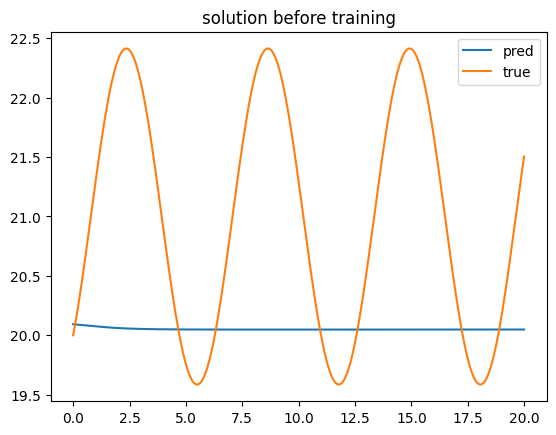

epoch: 0


100%|██████████| 300/300 [00:04<00:00, 71.88it/s]


loss_mse: 0.7817241361737252
loss_init: 0.47713247295543015
loss_total: 0.7864954589804014


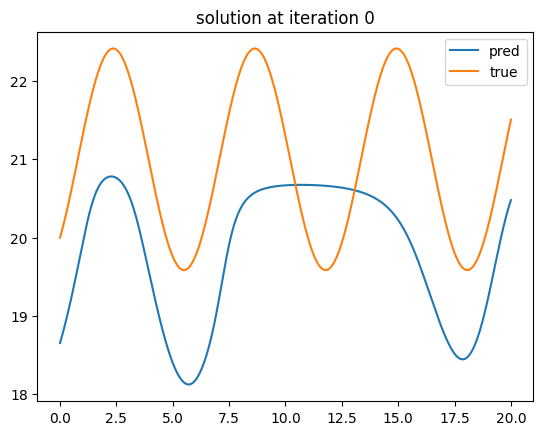

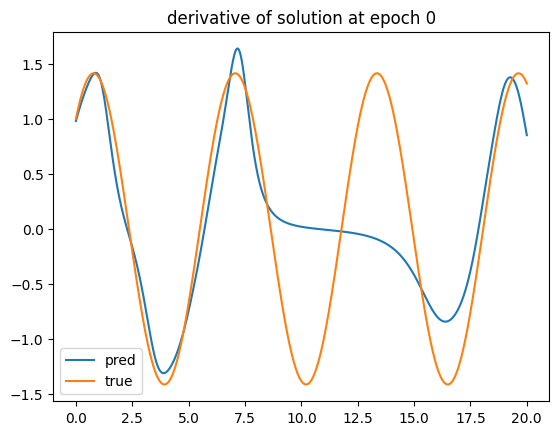

epoch: 1


100%|██████████| 300/300 [00:04<00:00, 73.77it/s]


loss_mse: 0.1777168055670336
loss_init: 0.29109125755404724
loss_total: 0.1806277184622983


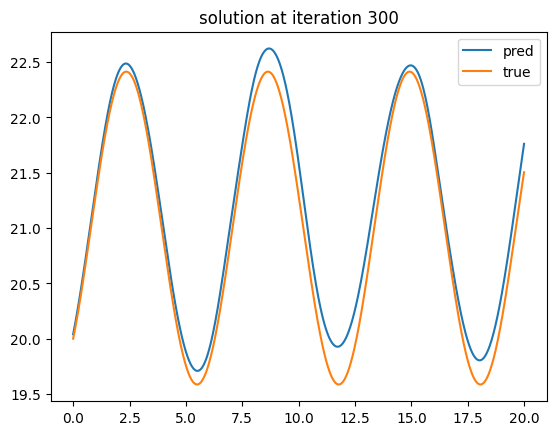

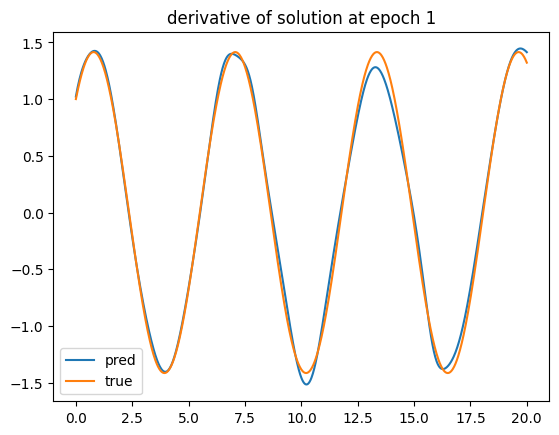

epoch: 2


100%|██████████| 300/300 [00:04<00:00, 72.51it/s]


loss_mse: 0.0028099535471604515
loss_init: 0.000584565947331915
loss_total: 0.0028157992063400647


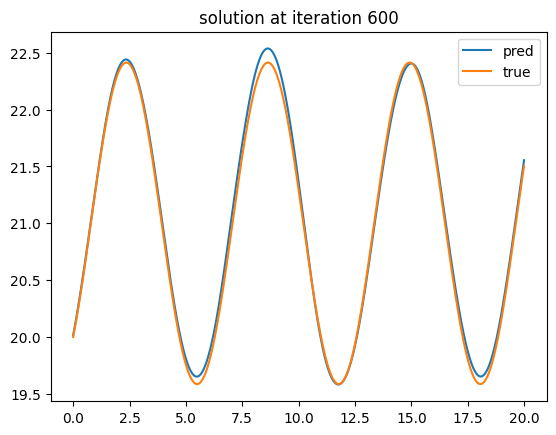

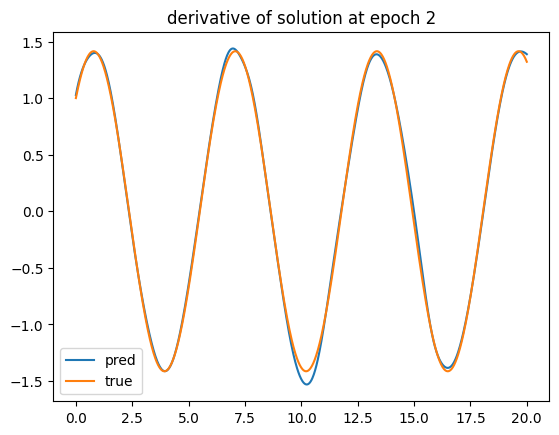

epoch: 3


100%|██████████| 300/300 [00:04<00:00, 73.42it/s]


loss_mse: 0.0017067097877346289
loss_init: 0.00015731683427778383
loss_total: 0.0017082829575520008


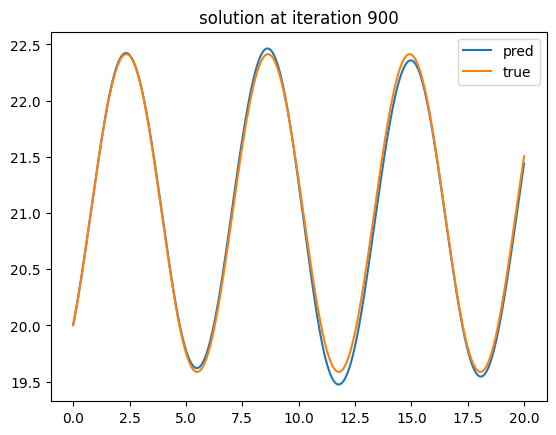

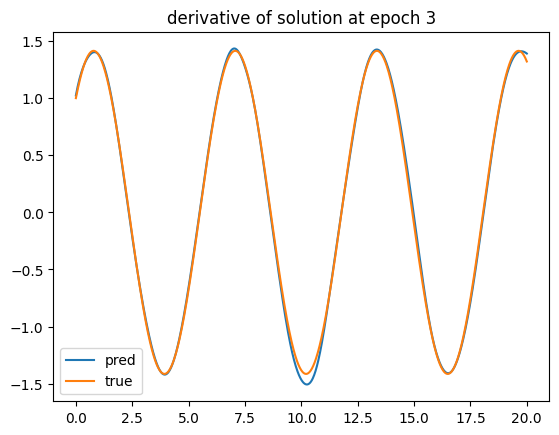

epoch: 4


100%|██████████| 300/300 [00:04<00:00, 73.25it/s]


loss_mse: 0.001490811614979369
loss_init: 6.462034602009226e-05
loss_total: 0.00149145781819243


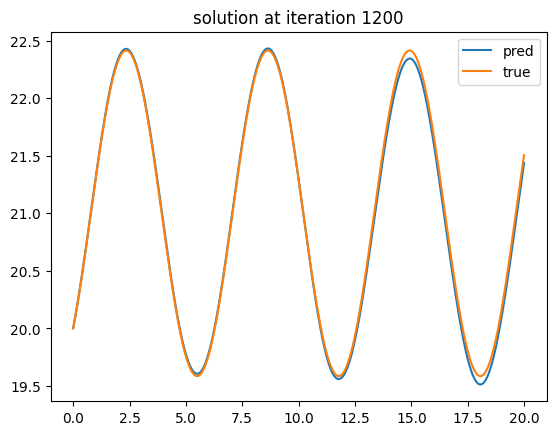

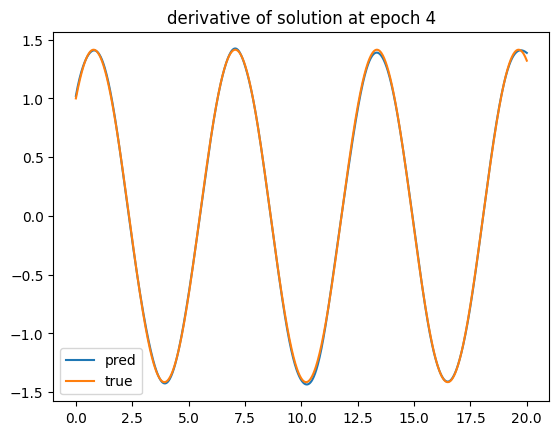

epoch: 5


100%|██████████| 300/300 [00:04<00:00, 73.94it/s]


loss_mse: 0.0013530296854150946
loss_init: 5.0151125869888346e-05
loss_total: 0.0013535311979891655


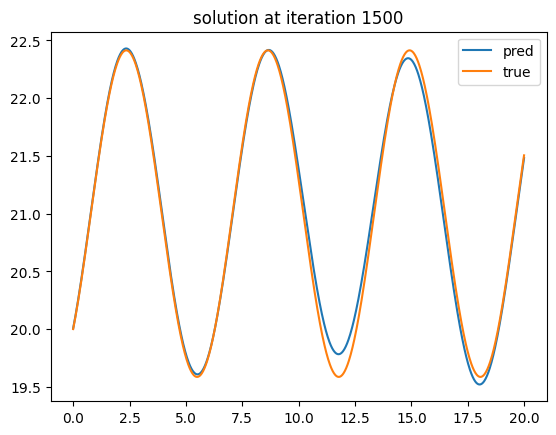

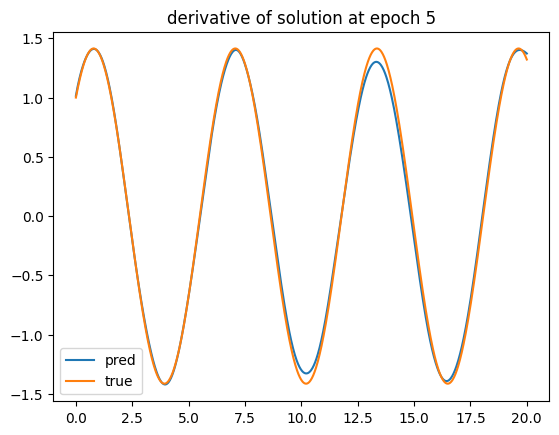

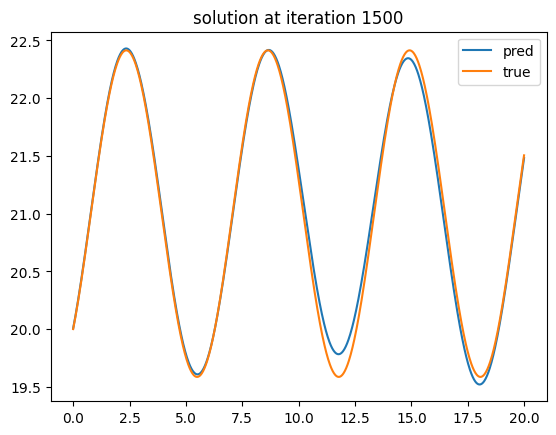

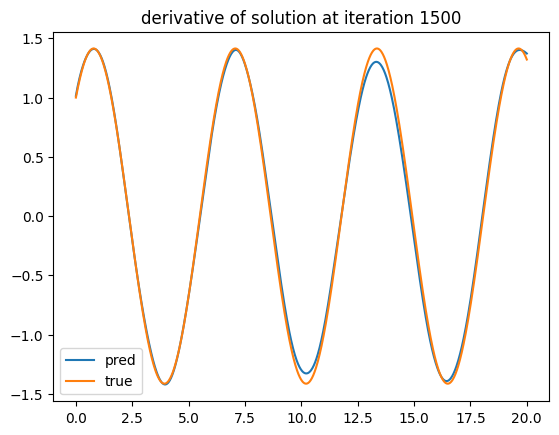

In [4]:
from traceback import print_tb




model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 6

loss_list = {
    "mse": [],
    "init": [],
    "total": []
    
}

visualized_imgs = []

val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

visualized_imgs.append(plt.gcf())

#　学習開始時点での解を描画
plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend() 
plt.title(f"solution before training")
plt.show()



for epoch in range(num_epochs):
    
    print(f"epoch: {epoch}")
    
    loss_list["mse"].append(0)
    loss_list["init"].append(0)
    loss_list["total"].append(0)
    
    from tqdm import tqdm
    
    for x in tqdm(dataloader):
        
        
        optimizer.zero_grad()
        
        x : torch.Tensor = x.to(device)
        x.requires_grad = True
        y_prime : torch.Tensor = Diff_Eq.y_prime(x, Diff_Eq.y(x))
        
        y_pred: torch.Tensor = model(x)
        

        y_prime_pred = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
        
        # print(y_prime_pred)
        
        loss_mse = F.mse_loss(y_prime_pred, y_prime)

        
        y0_pred  = model(torch.tensor([[Diff_Eq.x0]]).to(device))
        y0_true = torch.tensor([[Diff_Eq.y0()]]).to(device)
        loss_init = (y0_pred - y0_true) ** 2
        
        loss = loss_mse + loss_init * 0.01
        loss.backward()
        
        optimizer.step()
        
        loss_list["mse"][-1] += loss_mse.item()
        loss_list["init"][-1] += loss_init.item()
        loss_list["total"][-1] += loss.item()
    
    loss_list["mse"][-1] /= len(dataloader)
    loss_list["init"][-1] /= len(dataloader)
    loss_list["total"][-1] /= len(dataloader)
    
    print(f"loss_mse: {loss_list['mse'][-1]}")
    print(f"loss_init: {loss_list['init'][-1]}")
    print(f"loss_total: {loss_list['total'][-1]}")
    
    val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
    val_x.requires_grad = True
    val_y = model(val_x)
    
    visualized_imgs.append(plt.gcf())
    
    plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
    plt.legend() 
    plt.title(f"solution at iteration {epoch * len(dataloader)}")
    plt.show()
    

    
    # 微分値についても描画
    val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
    plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
    plt.legend()
    plt.title(f"derivative of solution at epoch {epoch}")
    plt.show()


val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend() 
plt.title(f"solution at iteration {epoch * len(dataloader)}")
plt.show()


# 微分値についても描画
val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
plt.legend()
plt.title(f"derivative of solution at iteration {epoch * len(dataloader)}")
plt.show()


In [5]:
# アニメーションとしてgifに保存
# 再生速度を設定する
import imageio

images = []
for img in visualized_imgs:
    img.savefig("tmp.png")
    images.append(imageio.imread("tmp.png"))
    
imageio.mimsave('result1.gif', images, fps=1)
    
        
import os
os.remove("tmp.png")


/tmp/ipykernel_3521/906336250.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("tmp.png"))


# 初期値補正バイアスを活用した場合

In [6]:




model: Net = Net()


model.bias = nn.Parameter(torch.tensor([0.0]))
model.bias.requires_grad = False


model.to(device)







Net(
  (fc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (5): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (6): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)

# 初期値補正バイアスを利用しなかった場合

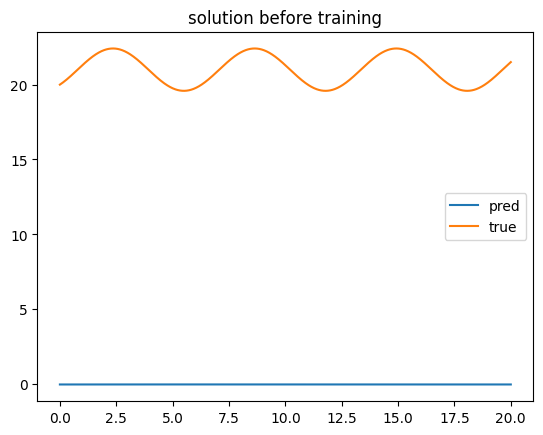

epoch: 0


100%|██████████| 300/300 [00:04<00:00, 70.83it/s]

loss_mse: 0.9096752858161926
loss_init: 240.56053527832032
loss_total: 3.3152805757522583


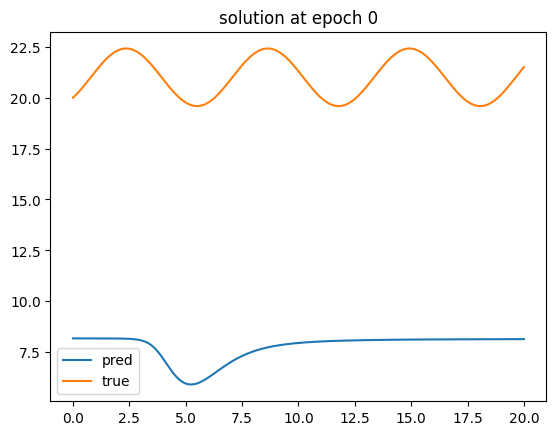

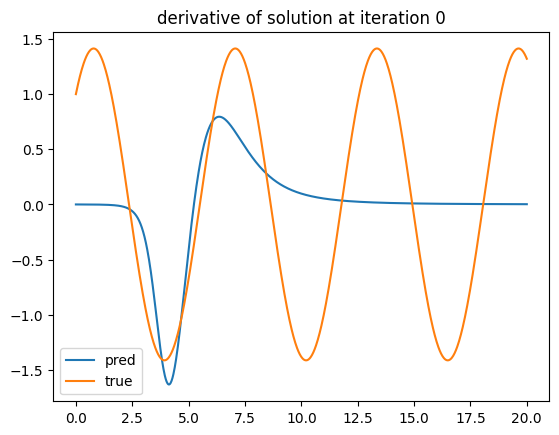

epoch: 1


100%|██████████| 300/300 [00:04<00:00, 70.09it/s]


loss_mse: 0.7984564667940139
loss_init: 88.4314440536499
loss_total: 1.6827708872159322


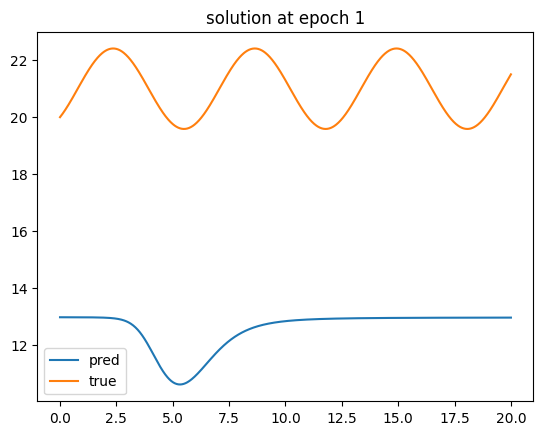

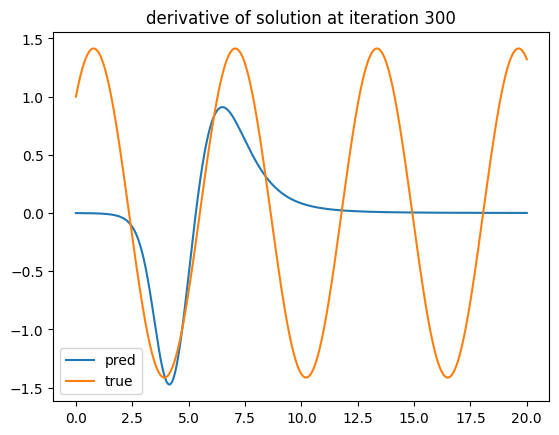

epoch: 2


100%|██████████| 300/300 [00:04<00:00, 69.59it/s]


loss_mse: 0.7774460852146149
loss_init: 28.66824803352356
loss_total: 1.064128560423851


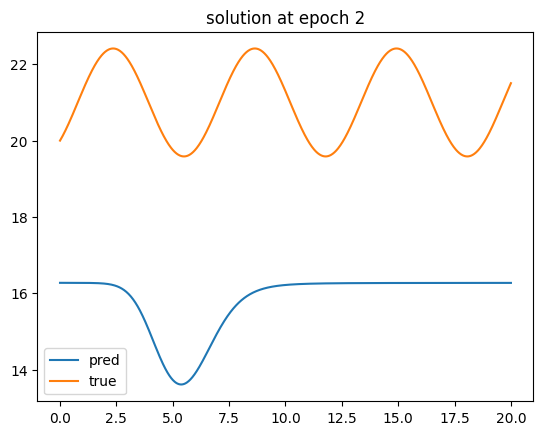

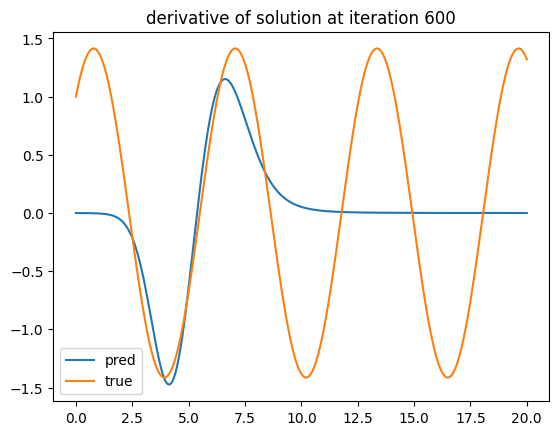

epoch: 3


100%|██████████| 300/300 [00:04<00:00, 70.12it/s]


loss_mse: 0.7501685229937235
loss_init: 7.211633960405986
loss_total: 0.8222848614056905


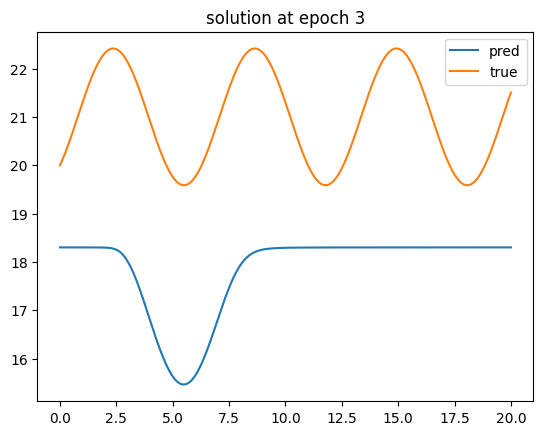

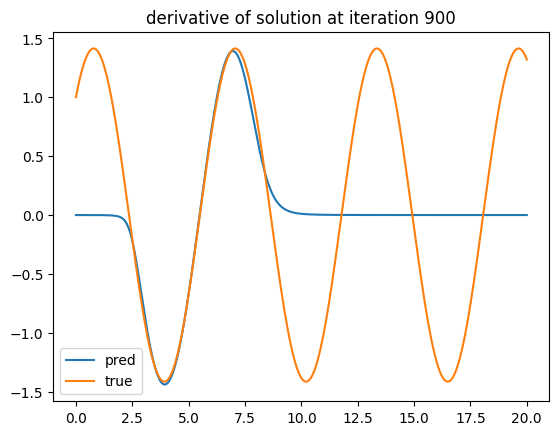

epoch: 4


100%|██████████| 300/300 [00:04<00:00, 71.23it/s]


loss_mse: 0.732956427137057
loss_init: 1.3206203372279803
loss_total: 0.7461626297235489


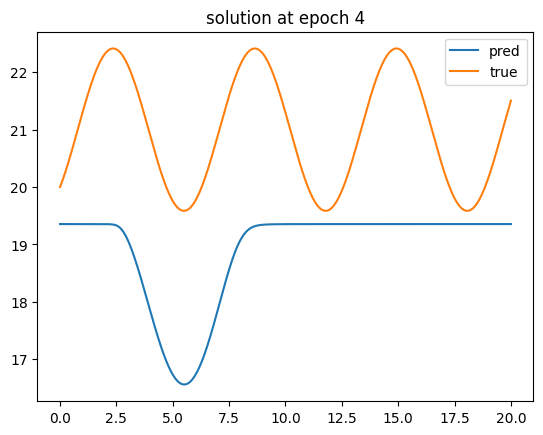

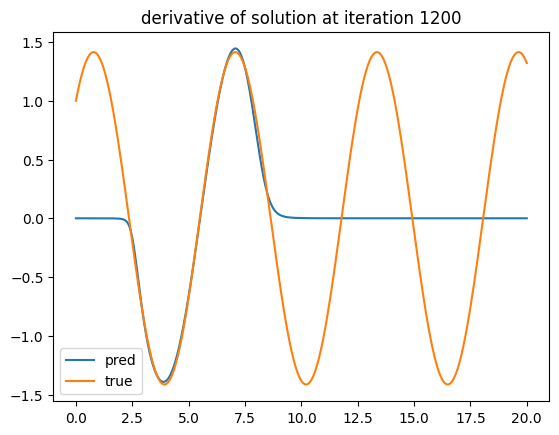

epoch: 5


100%|██████████| 300/300 [00:04<00:00, 71.11it/s]

loss_mse: 0.7281026287873587
loss_init: 0.16552466663221518
loss_total: 0.7297578750054041


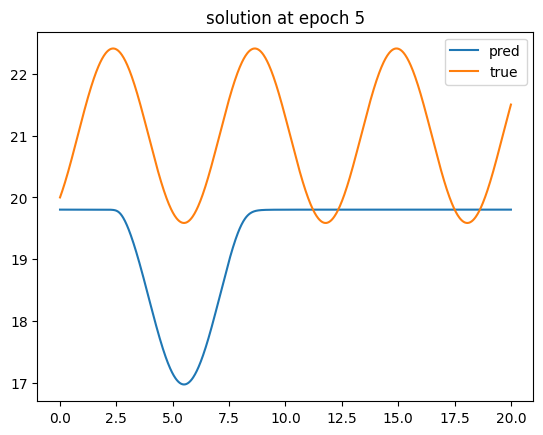

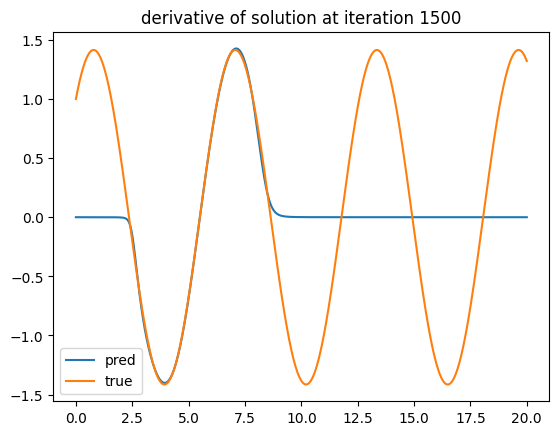

epoch: 6


100%|██████████| 300/300 [00:04<00:00, 69.38it/s]


loss_mse: 0.7294376548131307
loss_init: 0.01354119276162237
loss_total: 0.7295730664332708


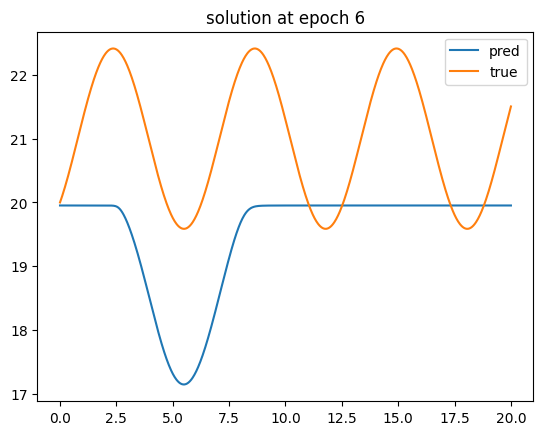

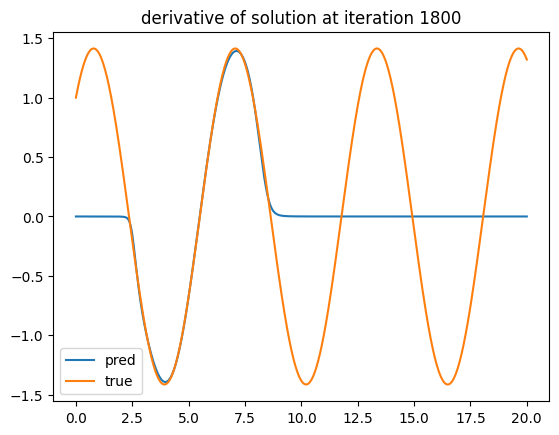

epoch: 7


100%|██████████| 300/300 [00:04<00:00, 70.36it/s]


loss_mse: 0.7284842689832052
loss_init: 0.0006884022425704946
loss_total: 0.7284911529223124


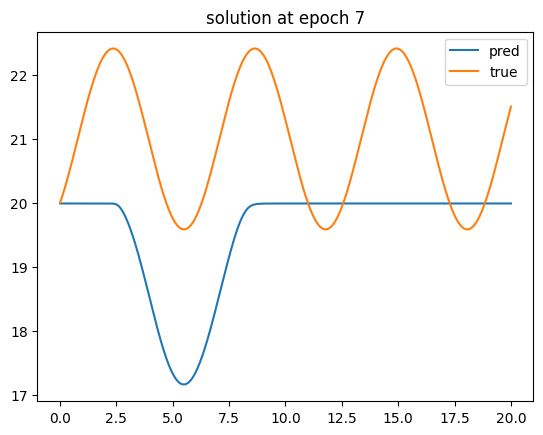

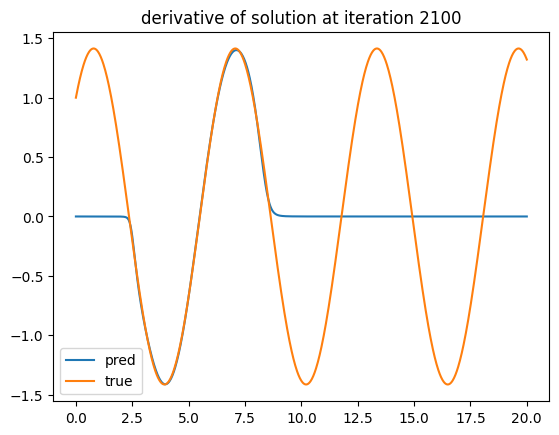

epoch: 8


100%|██████████| 300/300 [00:04<00:00, 70.89it/s]

loss_mse: 0.7303304185469945
loss_init: 2.1628713257086928e-05
loss_total: 0.730330634911855


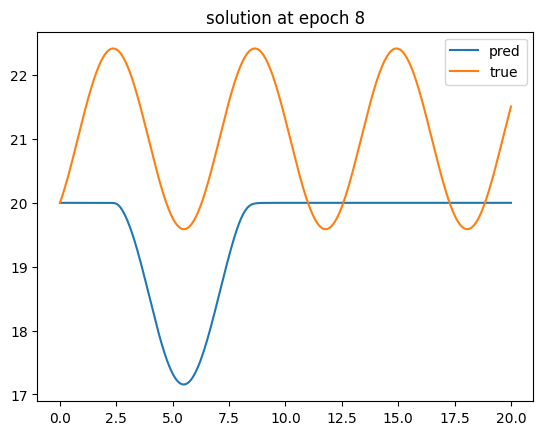

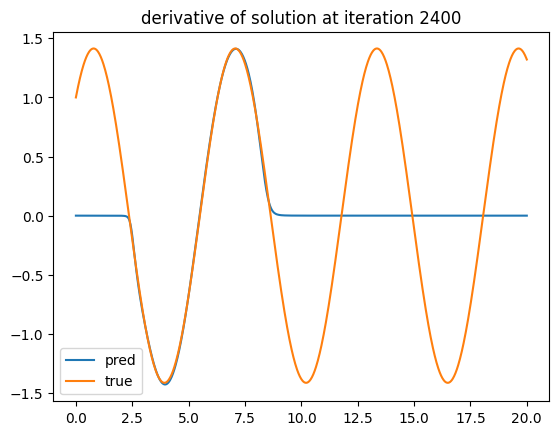

epoch: 9


100%|██████████| 300/300 [00:04<00:00, 69.75it/s]


loss_mse: 0.7276447918017706
loss_init: 5.99786047435676e-07
loss_total: 0.7276447918017706


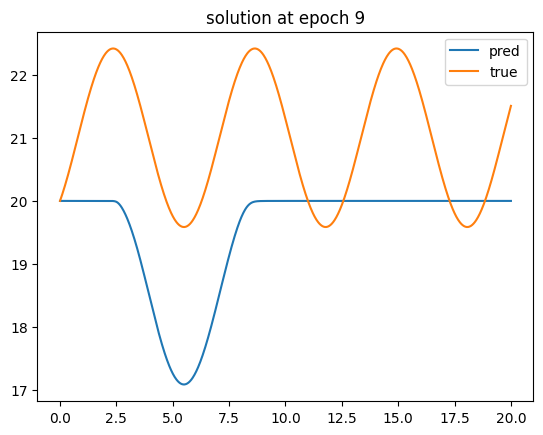

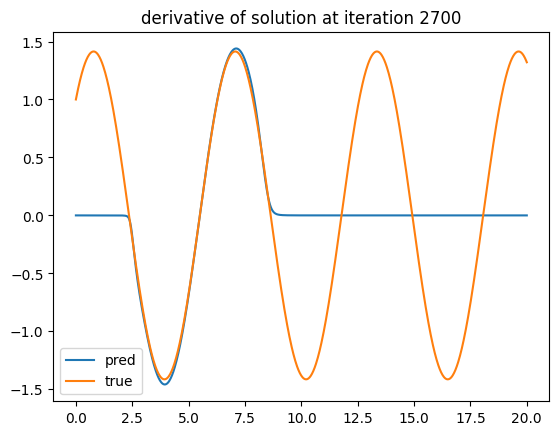

epoch: 10


100%|██████████| 300/300 [00:04<00:00, 70.54it/s]


loss_mse: 0.7283490073680877
loss_init: 6.129579560365528e-08
loss_total: 0.7283490073680877


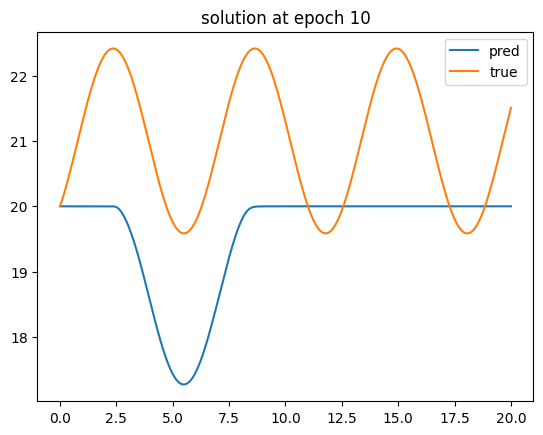

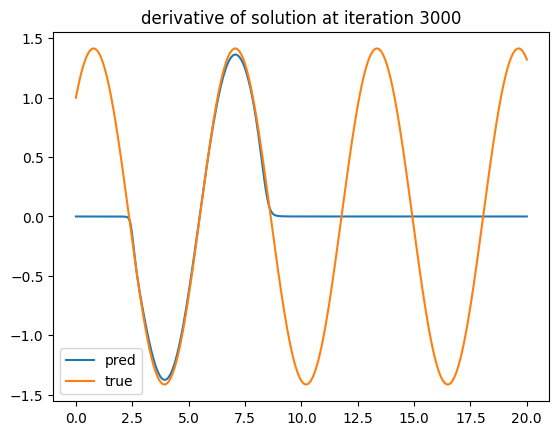

epoch: 11


100%|██████████| 300/300 [00:04<00:00, 69.91it/s]


loss_mse: 0.7295438987016678
loss_init: 2.4739965738262982e-08
loss_total: 0.7295438987016678


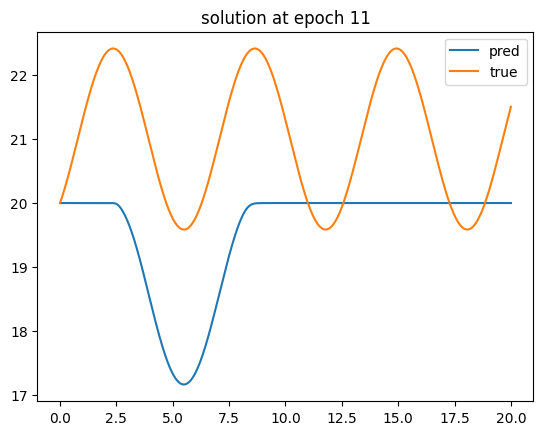

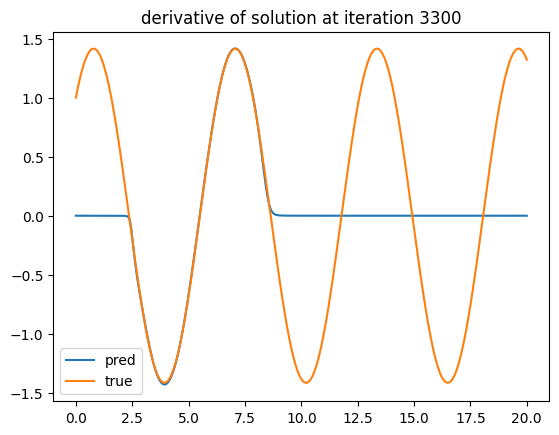

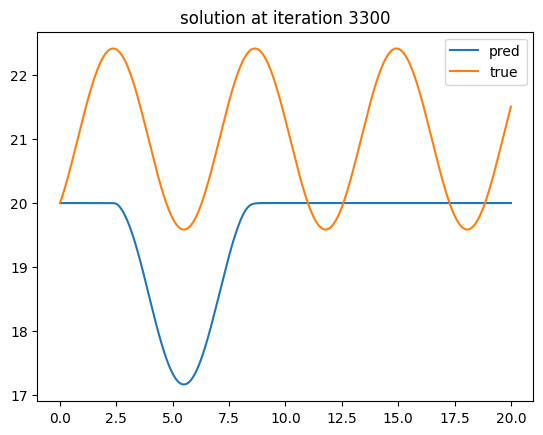

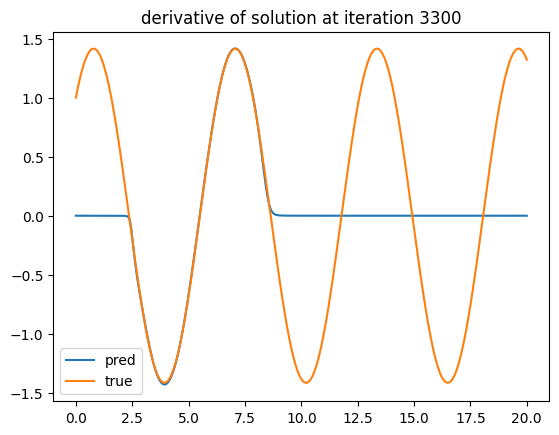

In [7]:
from traceback import print_tb

optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 12

loss_list = {
    "mse": [],
    "init": [],
    "total": []
}

visualized_imgs = []

val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

visualized_imgs.append(plt.gcf())

#　学習開始時点での解を描画
plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend()

plt.title(f"solution before training")
plt.show()



for epoch in range(num_epochs):
    
    print(f"epoch: {epoch}")
    
    loss_list["mse"].append(0)
    loss_list["init"].append(0)
    loss_list["total"].append(0)
    
    from tqdm import tqdm
    
    for x in tqdm(dataloader):
        
        
        optimizer.zero_grad()
        
        x : torch.Tensor = x.to(device)
        x.requires_grad = True
        y_prime : torch.Tensor = Diff_Eq.y_prime(x, Diff_Eq.y(x))
        
        y_pred: torch.Tensor = model(x)
        

        y_prime_pred = torch.autograd.grad(y_pred.sum(), x, create_graph=True)[0]
        
        # print(y_prime_pred)
        
        loss_mse = F.mse_loss(y_prime_pred, y_prime)

        
        y0_pred  = model(torch.tensor([[Diff_Eq.x0]]).to(device))
        y0_true = torch.tensor([[Diff_Eq.y0()]]).to(device)
        loss_init = (y0_pred - y0_true) ** 2
        
        loss = loss_mse + loss_init * 0.01
        loss.backward()
        
        optimizer.step()
        
        loss_list["mse"][-1] += loss_mse.item()
        loss_list["init"][-1] += loss_init.item()
        loss_list["total"][-1] += loss.item()
    
    loss_list["mse"][-1] /= len(dataloader)
    loss_list["init"][-1] /= len(dataloader)
    loss_list["total"][-1] /= len(dataloader)
    
    print(f"loss_mse: {loss_list['mse'][-1]}")
    print(f"loss_init: {loss_list['init'][-1]}")
    print(f"loss_total: {loss_list['total'][-1]}")
    
    val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
    val_x.requires_grad = True
    val_y = model(val_x)
    
    visualized_imgs.append(plt.gcf())
    
    plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
    plt.legend() 
    plt.title(f"solution at epoch {epoch}")
    plt.show()
    

    
    
    # 微分値についても描画
    val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
    plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
    plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
    plt.legend()
    plt.title(f"derivative of solution at iteration {epoch * len(dataloader)}")
    plt.show()


val_x = torch.linspace(dataloader.dataset.x_from, dataloader.dataset.x_to, 1000).to(device).view(-1, 1)
val_x.requires_grad = True
val_y = model(val_x)

plt.plot(val_x.cpu().detach().numpy(), val_y.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y(val_x).cpu().detach().numpy(), label="true")
plt.legend() 
plt.title(f"solution at iteration {epoch * len(dataloader)}")
plt.show()


# 微分値についても描画
val_y_prime = torch.autograd.grad(val_y.sum(), val_x, create_graph=True)[0]
plt.plot(val_x.cpu().detach().numpy(), val_y_prime.cpu().detach().numpy(), label="pred")
plt.plot(val_x.cpu().detach().numpy(), Diff_Eq.y_prime(val_x, val_y).cpu().detach().numpy(), label="true")
plt.legend()
plt.title(f"derivative of solution at iteration {epoch * len(dataloader)}")
plt.show()


In [8]:
model.bias

Parameter containing:
tensor([0.], device='cuda:0')

In [9]:
# アニメーションとしてgifに保存
# 再生速度を設定する
import imageio

images = []
for img in visualized_imgs:
    img.savefig("tmp.png")
    images.append(imageio.imread("tmp.png"))
    
imageio.mimsave('result2.gif', images, fps=1)
    
        
import os
os.remove("tmp.png")


/tmp/ipykernel_3521/1622330007.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("tmp.png"))
